<h1> CLEESE: A SHORT TUTORIAL </h1>

![cleese](tutorial/pics/silly-walk.jpg)

CLEESE ("Ministry of Silly Speech") is a sound and image manipulation tool designed to generate an infinite number of possible stimuli; be it natural-sounding expressive variations around an original speech recording, or variations on the expression of a human face.

More precisely, CLEESE is currently composed of two engines: `PhaseVocoder` and `Mediapipe`.
* `PhaseVocoder` allows one to create random fluctuations around an audio file’s original contour of pitch, loudness, timbre and speed (i.e. roughly defined, its prosody). One of its foreseen applications is the generation of very many random voice stimuli for reverse correlation experiments.
* `Mediapipe` uses [mediapipe](https://google.github.io/mediapipe/)'s Face Mesh API to introduce random or precomputed deformation in the expression of a visage on an image. This engine was designed to produce batches of deformed faces for reverse correlation experiments.

CLEESE is a free, standalone Python module, distributed under an open-source MIT Licence on the IRCAM Forumnet plateform. It was designed by Juan José Burred, Emmanuel Ponsot and Jean-Julien Aucouturier (STMS, IRCAM/CNRS/Sorbonne Université, Paris), with collaboration from Pascal Belin (Institut des Neurosciences de la Timone, Aix-Marseille Université), with funding from the European Research Council (CREAM 335536, 2014-2019, PI: JJ Aucouturier), and support for face deformation was added by Lara Kermarec (2022).

This notebook is a short tutorial on how to use CLEESE to manipulate sounds, and is a companion to the PDF documentation available [here](https://github.com/creamlab/cleese/raw/master/doc/CLEESE_manual_v2.0.pdf).

<h2> Installation </h2>

### Python / Jupyter Notebook

CLEESE being a Python package, you will to first have a working installation of Python (versions 2.7 or 3). In addition, to run this tutorial, you will need Jupyter Notebook as well as a number of commonly used packages for scientific computing. For new users, we highly recommend [installing Anaconda](https://www.continuum.io/downloads)>. Anaconda conveniently installs Python, the Jupyter Notebook, and other commonly used packages for scientific computing and data science.

Use the following installation steps:
* Download [Anaconda](https://www.continuum.io/downloads). We recommend downloading Anaconda’s  Python 2.7 version.
* Install the version of Anaconda which you downloaded, following the instructions on the download page.

### CLEESE

* Install CLEESE from your shell/command line: ```pip install cleese-stim```
* Launch Jupyter notebook from your shell/command line ```jupyter notebook``` and navigate to this tutorial .ipynb file
* Try running the following cell, as a test. It should import cleese as well as a number of scientific packages included in the Anaconda distribution, and return with no error. 

In [1]:
import cleese_stim as cleese
from cleese_stim.engines import PhaseVocoder

import scipy.io.wavfile as wav
import numpy as np
from IPython.display import Markdown, display, Audio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 5, 2

### PYSPTK

While CLEESE is standalone and does not require any further packages to be work, this tutorial uses extra functions from the [Python Speech Processing ToolKit (pysptk)](http://pysptk.readthedocs.io/en/latest/), to extract and visualize the pitch of the audio files manipulated here. 

* If you're on a Mac, you might need to install the Xcode Command Line Tools before installing pysptk. To do so, run ```xcode-select --install``` on the terminal.
* Install pysptk by running ```pip install pysptk```, or alternatively follow the pysptk installation instructions [here](http://pysptk.readthedocs.io/en/latest/introduction.html)
* Run the following cell for a test

In [3]:
import pysptk
PITCH_BOUNDS=[50,400]
PITCH_WIN = .001 #s
def extract_pitch(x, sr, win=PITCH_WIN, bounds=PITCH_BOUNDS): 
    hop_size = np.floor(sr * win)
    min_f0, max_f0 = bounds
    pitch = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_size, min=min_f0, max=max_f0, otype=1)
    times = 1000*np.arange(len(pitch))*hop_size/sr
    return np.array(pitch), times

<h2> Basic sound manipulation with CLEESE </h2>

### Random pitch profile in a single utterance

The most basic usage scenario of CLEESE is to input a single recording (ex. the French word "vraiment" - "really", recorded by a single male speaker ```sounds/male_vraiment_flattened.wav```)

In [4]:
input_file = "./sounds/male_vraiment_flattened.wav"
wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
Audio(data=wave_in, rate=sr)

and use CLEESE to transform the sound with a random pitch profile. This, like all cleese operations, is done by passing to the main cleese function `cleese.process_data` a configuration file which specifies the manipulation we want. Here: cut the file in `pitch.window.count = 6` time segments, draw a random pitch shift factor at each segment boundary from a Gaussian distribution centered on 0 and standard deviation `pitch.std = 300`cents, and interpolate between segment boundaries using linear `pitch.BPFType = "ramp"`. (See PDF documentation for more information)

```toml
[pitch]
# pitch transposition window in seconds. If 0 : static transformation
window.len = 0.11

# number of pitch transposition windows. If 0 : static transformation
window.count = 6

# 's': force winlength in seconds,'n': force number of windows (equal length)
window.unit = 'n'

# standard deviation (cents) for random transposisiton (Gaussian distrib for now)
std = 300

# truncate distribution values (factor of std)
trunc = 1

# type of breakpoint function:
#      'ramp': linear interpolation between breakpoints
#      'square': square BPF, with specified transition times at edges
BPFtype = 'ramp'

# in s: transition time for square BPF
trTime = 0.02
```

Original file:

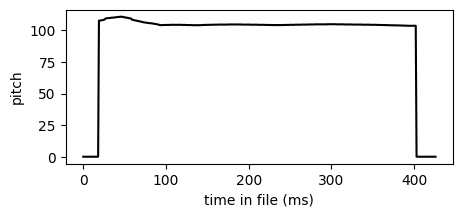

pitch variation 1/1


Transformed file:

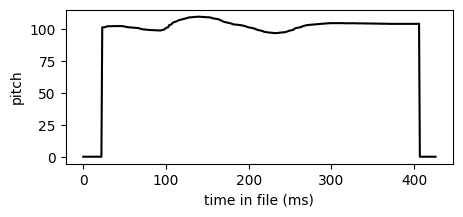

In [5]:
input_file = "./sounds/male_vraiment_flattened.wav"
config_file = "./configs/random_pitch_profile.toml"

# read input wavefile, and extract pitch for display (unnecessary for cleese.process below)
wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
display(Markdown("Original file:"))
Audio(data=wave_in, rate=sr)
pitch,times = extract_pitch(wave_in,sr)
_=plt.plot(times, pitch, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

# CLEESE
wave_out,bpf_out = cleese.process_data(PhaseVocoder, wave_in, config_file, sample_rate=sr)

# display transformed file
display(Markdown("Transformed file:"))
Audio(data=wave_out, rate=sr)
pitch,times = extract_pitch(wave_out,sr)
_=plt.plot(times, pitch, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

<h3> Random speed profile in a song </h3>

CLEESE can process longer files than a single word and, instead of manipulating pitch, can manipulate the duration of each portion of the file. To demonstrate this, we use CLEESE to randomly stretch each note in a recording of a song (the French song "Joyeux Anniversaire" / "Happy Birthday", sung by a female singer)

In [6]:
input_file = "./sounds/female_anniversaire_isochrone.wav"
wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
Audio(data=wave_in, rate=sr)

C:\Users\Aucouturier\AppData\Roaming\Python\Python37\site-packages\cleese_stim\engines\phase_vocoder\cleeseProcess.py:214: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampleRate, wave = wav.read(fileName)


This, as above, is done by passing to `cleese.process_data` a configuration file which specifies the manipulation we want. Here: cut the file in `stretch.window.len = 0.5` second time segments, draw a random stretch shift factor at each segment boundary from a Gaussian distribution centered on 1.0 and standard deviation `stretch.std = 1.5` (where factors >1 correspond to a time stretch, and factors <1 correspond to a time compression), and interpolate between segment boundaries using linear `stretch.BPFType = "ramp"`. (See PDF documentation for more information)

```toml
[stretch]

window.len = 0.1
window.count = 5
window.unit = 'n'

# stretching factor. >1: expansion, <1: compression
std = 1.5
trunc = 1
BPFtype = 'ramp'
trTime = 0.05
```

Original file:

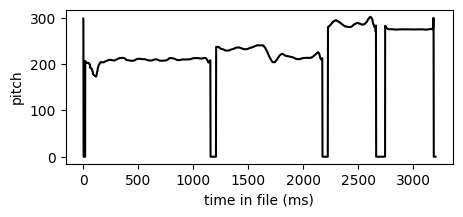

stretch variation 1/1


Transformed file:

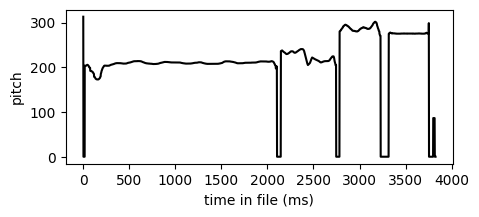

In [7]:
input_file = "./sounds/female_anniversaire_isochrone.wav"
config_file = "./configs/random_speed_profile.toml"

# read input wavefile, and extract pitch for display (unnecessary for cleese.process below)
wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
display(Markdown("Original file:"))
Audio(data=wave_in, rate=sr)
pitch,times = extract_pitch(wave_in,sr)
_=plt.plot(times, pitch, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

# CLEESE
wave_out,bpf_out = cleese.process_data(PhaseVocoder, wave_in, config_file, sample_rate=sr)

# display transformed file
display(Markdown("Transformed file:"))
Audio(data=wave_out, rate=sr)
pitch,times = extract_pitch(wave_out,sr)
_=plt.plot(times, pitch, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

<h3> Batched transforms </h3>

Instead of generating output files one at a time, CLEESE can be used to generate large numbers of manipulated files, each randomly generated using parameters specified in config files as above. This is achieve by pusing cleese.generate_stimuli `cleese.generate_stimuli(PhaseVocoder, input_file, config_file)`. Output files are not returned by the function, but directly written in `main.outPath`, and the number of output files generated is given by `main.numFiles`, all of which are found in the configuration file:

```toml
[main]

# output root folder
outPath = "./output/"

# number of output files to generate (for random modifications)
numFiles = 10

# apply transformation in series (True) or parallel (False)
chain = true

# transformations to apply
transf = ["pitch"]

# generate experiment folder with name based on current time
generateExpFolder = true
```

In [8]:
input_file = "./sounds/male_vraiment_flattened.wav"
config_file = "./configs/random_pitch_profile.toml"

# CLEESE
cleese.generate_stimuli(PhaseVocoder, input_file, config_file)


pitch variation 1/10
pitch variation 2/10
pitch variation 3/10
pitch variation 4/10
pitch variation 5/10
pitch variation 6/10
pitch variation 7/10
pitch variation 8/10
pitch variation 9/10
pitch variation 10/10


<h3> Chained transforms </h3>

CLEESE can process files with a series of transformations that follow each other, e.g. first time-stretch the file, then pitch-shift it. This is done by specifying keyword `chain = true` under the configuration section `[main]`, as well as the list of transformations to be applied, e.g. here `transf = ['pitch','stretch']`.  

```toml
[main]

# output root folder
outPath = "./output/"

# number of output files to generate (for random modifications)
numFiles = 10

# apply transformation in series (True) or parallel (False)
chain = true

# transformations to apply
transf = ["pitch", "stretch"]

# generate experiment folder with name based on current time
generateExpFolder = true
```

In [10]:
input_file = "./sounds/male_vraiment_flattened.wav"
config_file = "./configs/chained_pitch_stretch.toml"

# CLEESE
cleese.generate_stimuli(PhaseVocoder, input_file, config_file)

pitch variation 1/10
pitch variation 2/10
pitch variation 3/10
pitch variation 4/10
pitch variation 5/10
pitch variation 6/10
pitch variation 7/10
pitch variation 8/10
pitch variation 9/10
pitch variation 10/10
pitch_gain variation 1/10
pitch_gain variation 2/10
pitch_gain variation 3/10
pitch_gain variation 4/10
pitch_gain variation 5/10
pitch_gain variation 6/10
pitch_gain variation 7/10
pitch_gain variation 8/10
pitch_gain variation 9/10
pitch_gain variation 10/10


<h2> Advanced use </h2>

<h3> Flattening files </h3>

When applying CLEESE to generate stimuli for reverse correlation, it is often advisable to use base stimuli that are as flat as possible (e.g., if randomizing pitch, start with a sound that has constant pitch). CLEESE can be used to flatten an existing recording, using the trick of not letting the tool generate its own random breakpoint function, but rather providing it with a custom function that inverts the natural pitch variations found in the original file. We demonstrate this with an original, non flattened recording of the word "vraiment". 

In [11]:
input_file = "./sounds/male_vraiment_original.wav"
wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
Audio(data=wave_in, rate=sr)

The file has a soft, down-ward pitch contour, as show in the analysis below

Original file:

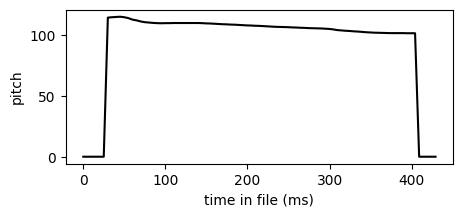

In [12]:
# analyse original file
wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
display(Markdown("Original file:"))
pitch,times = extract_pitch(wave_in,sr, win=0.005, bounds=[50, 200])
# display original file
_=plt.plot(times, pitch, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

To flatten this existing contour, we construct a custom breakpoint function that passes through the pitch shift values needed to shift the contour down to a constant pitch value, arbitrarily set here at 100Hz. 

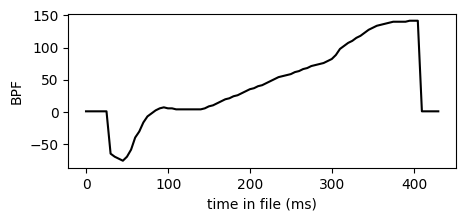

In [13]:
mean_pitch = 110.
def difference_to_cents(pitch, ref_pitch):
    if pitch >0:
        return -1200*np.log2(pitch/ref_pitch)
    else:
        return 1
bpf_times = times/1000
bpf_val = np.array([difference_to_cents(hz, mean_pitch) for hz in pitch])
# display original file
_=plt.plot(1000*bpf_times, bpf_val, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('BPF')
plt.show()

We then apply this custom BPF to the original file, using `cleese.process_data(PhaseVocoder, wave_in, config_file, sample_rate=sr, BPF=bpf)` (passing audio data as input, because we don't need batch mode here). 

pitch variation 1/1


Transformed file:

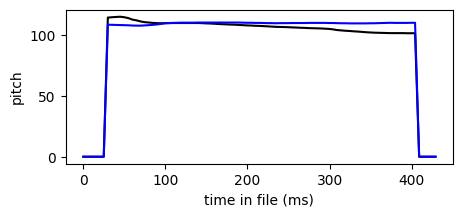

In [14]:
config_file = "./configs/random_pitch_profile.toml"

# CLEESE
bpf = np.column_stack((bpf_times,bpf_val))
wave_out,bpf_out = cleese.process_data(PhaseVocoder, wave_in, config_file, sample_rate=sr, BPF=bpf)

# display transformed file
display(Markdown("Transformed file:"))
Audio(data=wave_out, rate=sr)
pitch_f,times_f = extract_pitch(wave_out,sr, win=0.005, bounds=[50, 200])
_=plt.plot(times, pitch, 'k')
_=plt.plot(times_f, pitch_f, 'b')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

<h3> Using custom breakpoints (1) </h3>

Instead of generating linearly spaced time windows (or, as called here, breakpoints), CLEESE supports a list of externally provided time positions. To demonstrate this, we use CLEESE to stretch the duration of each note in the song "Joyeux Anniversaire". 

In [15]:
input_file = "./sounds/female_anniversaire_isochrone.wav"
wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
Audio(data=wave_in, rate=sr)

To find note boundaries, we can e.g. use an external audio editor such as <a href="https://www.audacityteam.org"> Audacity</a>, and measure time positions between notes as ```[0.027, 0.634, 1.137, 1.647, 2.185, 2.649, 3.181]```. 
<img src="tutorial/pics/audacity.png" alt="Audacity" style="width: 600px;"/>

We can then generate a breakpoint function with `cleese.create_BPF` which uses these time points and parameters loaded from the stretch config file `config_file`. This BPF can then be passed to `cleese.process_data` as argument. 

Original file:

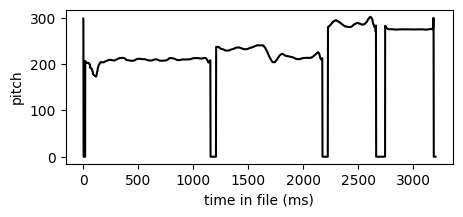

stretch variation 1/1


Transformed file:

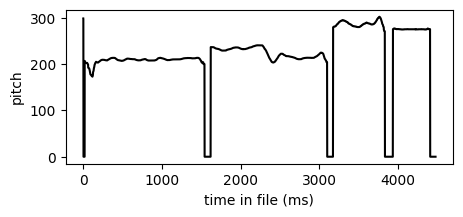

In [16]:
input_file = "./sounds/female_anniversaire_isochrone.wav"
config_file = "./configs/random_speed_profile.toml"

# display original file
wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
display(Markdown("Original file:"))
Audio(data=wave_in, rate=sr)
pitch,times = extract_pitch(wave_in,sr)
_=plt.plot(times, pitch, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

# CLEESE
time_points = np.array([0.027, 0.634, 1.137, 1.647, 2.185, 2.649, 3.181]) # values found in audacity
num_points = len(time_points)
bpf = PhaseVocoder.create_BPF(
    'stretch',config_file,time_points,num_points,0)   
wave_out,bpf_out = cleese.process_data(
    PhaseVocoder, wave_in, config_file, sample_rate=sr, BPF=bpf)

# display transformed file
display(Markdown("Transformed file:"))
Audio(data=wave_out, rate=sr)
pitch,times = extract_pitch(wave_out,sr)
_=plt.plot(times, pitch, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

<h3> Using custom breakpoints (2) </h3>

The following example shows how to pass fixed breakpoints to both a stretch and a pitch transform, thus generating a random melody of notes that have both random duration and random pitch.

Original file:

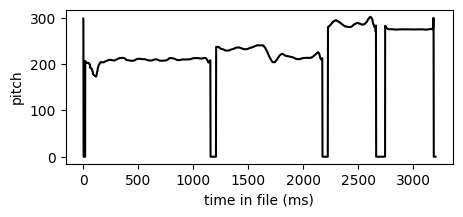

stretch variation 1/1


Stretched file:

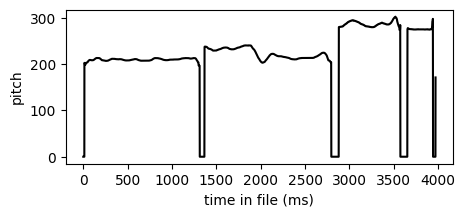

pitch variation 1/1


Pitched file:

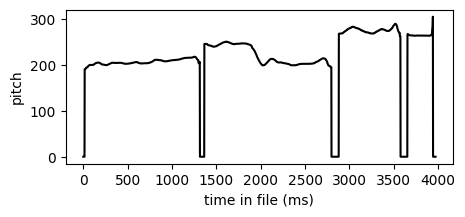

In [18]:
input_file = "./sounds/female_anniversaire_isochrone.wav"
config_file_pitch = "./configs/random_pitch_profile.toml"
config_file_stretch = "./configs/random_speed_profile.toml"

# display original file
wave_in, sr, _ = PhaseVocoder.wavRead(input_file)
display(Markdown("Original file:"))
Audio(data=wave_in, rate=sr)
pitch,times = extract_pitch(wave_in,sr)
_=plt.plot(times, pitch, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

# CLEESE
time_points = np.array([0.027, 0.634, 1.137, 1.647, 2.185, 2.649, 3.181]) # values found in audacity
num_points = len(time_points)
bpf_stretch = PhaseVocoder.create_BPF(
    'stretch',config_file_stretch,time_points,num_points,0)   
# print bpf_stretch
wave_out,bpf_out = cleese.process_data(
        PhaseVocoder,
        wave_in,
        config_file_stretch,
        sample_rate=sr,
        BPF=bpf_stretch)

# display transformed file
display(Markdown("Stretched file:"))
Audio(data=wave_out, rate=sr)
pitch,times = extract_pitch(wave_out,sr)
_=plt.plot(times, pitch, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()
   
bpf_pitch = PhaseVocoder.create_BPF(
    'pitch',config_file_pitch,time_points,num_points,0)   
# print bpf_pitch
wave_out,bpf_out = cleese.process_data(PhaseVocoder, wave_out, config_file_pitch, sample_rate=sr, BPF=bpf_pitch)

# display transformed file
display(Markdown("Pitched file:"))
Audio(data=wave_out, rate=sr)
pitch,times = extract_pitch(wave_out,sr)
_=plt.plot(times, pitch, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()